# Package installation and module import

In [27]:
# YouTube API packages
# pip install --upgrade google-api-python-client
# pip install --upgrade google-auth-oauthlib google-auth-httplib2

In [ ]:
# Database packages
from googleapiclient.discovery import build
from dateutil import parser
import pandas as pd
from IPython.display import JSON
import isodate

# Data viz
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Environment
from dotenv import load_dotenv
import os

# Natural Language Processing (NLP)
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from wordcloud import WordCloud

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Data collection and preparation

In [29]:
api_key = os.getenv('api_key')

# Name of the YouTube channel: 'La Capital'
channel_ids = ['UCEwl20VxZ3AwOgiKMZtI1GQ']

In [30]:
api_service_name = "youtube"
api_version = "v3"

# Get credentials and create an API client
youtube = build(
    api_service_name, api_version, developerKey=api_key)

request = youtube.channels().list(
   part="snippet,contentDetails,statistics",
   id=','.join(channel_ids)
)
response = request.execute()


JSON(response)

<IPython.core.display.JSON object>

In [31]:
# Function to get channel stats in a DataFrame

def get_channel_stats(youtube, channel_ids):
    
    """
    Get channel stats
    
    Params:
    ------
    youtube: build object of Youtube API
    channel_ids: list of channel IDs
    
    Returns:
    ------
    dataframe with all channel stats for each channel ID
    
    """
    
    all_data = []
    
    request = youtube.channels().list(
        part="snippet,contentDetails,statistics",
        id=','.join(channel_ids)
    )
    response = request.execute()

    # Loop through items
    for item in response['items']:
        data = {'channelName': item['snippet']['title'],
                'subscribers': item['statistics']['subscriberCount'],
                'views': item['statistics']['viewCount'],
                'totalVideos': item['statistics']['videoCount'],
                'playlistId': item['contentDetails']['relatedPlaylists']['uploads']
        }
        
        all_data.append(data)

    # Create DataFrame    
    return pd.DataFrame(all_data)

In [32]:
# Verify that the function works
channel_stats = get_channel_stats(youtube, channel_ids)

channel_stats.head()

,channelName,subscribers,views,totalVideos,playlistId
0,La Capital,9420000,1995696971,336,UUEwl20VxZ3AwOgiKMZtI1GQ


In [33]:
# Function that uses playlist id to get video ids
# We need them to be able to browse through videos

def get_video_ids(youtube, playlist_id):
    
    video_ids = []
    
    request = youtube.playlistItems().list(
        part="snippet,contentDetails",
        playlistId=playlist_id,
        maxResults = 50
    )
    response = request.execute()
    
    for item in response['items']:
        video_ids.append(item['contentDetails']['videoId'])
        
    next_page_token = response.get('nextPageToken')
    while next_page_token is not None:
        request = youtube.playlistItems().list(
                    part='contentDetails',
                    playlistId = playlist_id,
                    maxResults = 50,
                    pageToken = next_page_token)
        response = request.execute()

        for item in response['items']:
            video_ids.append(item['contentDetails']['videoId'])

        next_page_token = response.get('nextPageToken')
        
    return video_ids

In [34]:
# Verify that the function works
playlist_id = 'UUEwl20VxZ3AwOgiKMZtI1GQ'

video_ids = get_video_ids(youtube, playlist_id)

video_ids

['NyqVnxmMq2k',
 'gJDJZGV_pKM',
 '4DwdEaMDTRo',
 'mPufqoACksA',
 'xiYcwrnndlA',
 'b3s6ZkmC8ks',
 'tvfxxgcY1X8',
 'Om6DbtiiFdU',
 'KHlZ2Hq5N7g',
 'cuZ9c4LTDhE',
 'JwIETdlc-4s',
 'ey6uojfPb8M',
 'DxKj0XaHb-o',
 'v_Rre7j2ToU',
 'i8_g7vlGS5U',
 'VdmTRqpzcL4',
 'Jz6EYarXef0',
 '2vcNKtMOz0I',
 'bBEgtDGkUto',
 'lywtDIoxggE',
 'thyLRUWkD3s',
 '80bdX3rYvBM',
 'erc4o4wSsLM',
 'KI3syBxaDvE',
 'rfiUkGOTAGc',
 '9WQigkAI7Ao',
 'a5ktKbXp9rE',
 'PQKiGE0TJXg',
 '-HuYqSUWj60',
 'LqVlIK8z_T4',
 'nqXc8hYJbd8',
 'p7CJN3PJBgU',
 '6R2ptfofcnM',
 'JVpI5-crl6w',
 'QD3EB60_k9o',
 'mXdSo3-MMt0',
 'YRzweIjujEE',
 'KzN9dTxcEW0',
 'QSaPYTlYsDQ',
 'pzRxqx6uXks',
 '7440e4DEsqU',
 'lmIy0JSN1RQ',
 'JcucZfp0TvM',
 'W6rOPWF1Hn8',
 'lQyfs1xNJck',
 'qrQTK1Ql-8c',
 'mv-SuZtx9-M',
 'ipwROZJbhz0',
 'bhW0-5K7gkg',
 'isCbQfieXLk',
 'P8MtJhDBPqI',
 'LMl6bGLXrpg',
 'MPD8wiNVPDU',
 'D0PSttJIZMY',
 'AqHkYXTxMJ8',
 'xIFXQZXbflo',
 '4EejsGr-MYY',
 'QjFR3XsIbvw',
 'OplsBGUzwOg',
 'DrWPRlRl84Q',
 'xTFJv7fg3i4',
 'SCp6MBkx_0Y',
 '8YBiS1

In [35]:
len(video_ids)

336

In [36]:
# Function that uses video ids to get video details and saves them in a DataFrame
def get_video_details(youtube, video_ids):

    all_video_info = []
    
    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute() 

        for video in response['items']:
            stats_to_keep = {'snippet': ['channelTitle', 'title', 'description', 'tags', 'publishedAt'],
                             'statistics': ['viewCount', 'likeCount', 'favouriteCount', 'commentCount'],
                             'contentDetails': ['duration', 'definition', 'caption']
                            }
            video_info = {}
            video_info['video_id'] = video['id']

            for k in stats_to_keep.keys():
                for v in stats_to_keep[k]:
                    try:
                        video_info[v] = video[k][v]
                    except:
                        video_info[v] = None

            all_video_info.append(video_info)
    
    return pd.DataFrame(all_video_info)

In [37]:
# Get video details
video_df = get_video_details(youtube, video_ids)
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption
0,NyqVnxmMq2k,La Capital,El famoso Sándwich Francés | Croque Madame | L...,Contacto directo: oscarlacapital@gmail.com\n——...,"[croque madame, sandwich de jamaon, receta des...",2023-09-04T21:00:08Z,1629159,93394,None,1469,PT9M14S,hd,false
1,gJDJZGV_pKM,La Capital,Freidora de Aire Pero con Humo | La Capital,Contacto directo: oscarlacapital@gmail.com\nPa...,"[ninja firewood, la capital, costillas de res,...",2023-08-28T21:00:16Z,1373948,72317,None,1816,PT11M47S,hd,false
2,4DwdEaMDTRo,La Capital,Picaña Infierno al Mezcal | La Capital,Contacto directo: oscarlacapital@gmail.com\n——...,"[picana a la parrilla, salsa negra, salsa haba...",2023-08-15T21:00:03Z,1607098,88152,None,1356,PT8M23S,hd,false
3,mPufqoACksA,La Capital,Taco y Torta al Pastor | La Capital,Contacto directo: oscarlacapital@gmail.com\n——...,"[tacos al pastor, al pastor receta, al pastor ...",2023-07-31T21:00:32Z,3071279,132400,None,1686,PT11M23S,hd,false
4,xiYcwrnndlA,La Capital,Aguachile de Ribeye pero Wagyu | La Capital,Contacto directo: oscarlacapital@gmail.com\n——...,"[aguachile, la capital, chiltepin, ribeye asad...",2023-07-19T21:00:29Z,1780054,84701,None,1560,PT10M25S,hd,false
...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,qQ1P2JPf_IU,La Capital,Queso fundido con Chorizo | Botana Fácil | La ...,Gran opción para botanear antes de una carne a...,"[queso fundido, queso gratinado, con chorizo, ...",2016-08-27T16:30:01Z,3778175,155066,None,3019,PT7M9S,hd,false
332,VcciYKH8hAM,La Capital,Verdaderos Camarones A LA DIABLA | La Capital,Después de varias malas experiencias en restau...,"[camarones a la diabla, camarones, mexican sea...",2016-08-21T16:30:00Z,3850831,122520,None,2704,PT5M56S,hd,false
333,0uDlaSepHL0,La Capital,Chilaquiles Verdes con Huevo | La Capital,El mejor desayuno y mi favorito siempre! Chila...,"[chilaquiles, chilaquiles verdes, chile habane...",2016-08-14T16:45:04Z,3880023,122263,None,5155,PT9M55S,hd,false
334,TtaybghWcow,La Capital,Pechuga Rellena de Camaron *ENVUELTA EN TOCINO...,Video de Aguachiles: https://goo.gl/nsRHPd\n\n...,"[pechuga de pollo, pechuga rellena, camarones,...",2016-08-10T14:51:50Z,1758858,70951,None,2707,PT12M36S,hd,false


In [38]:
# Rename columns (CamelCase to snake_case)
column_name_mapping = {
   'channelTitle': 'channel_title',
   'publishedAt': 'published_at',
   'viewCount': 'view_count',
   'likeCount': 'like_count',
   'favouriteCount': 'favorite_count',
   'commentCount': 'comment_count',
}

video_df = video_df.rename(columns= column_name_mapping)

video_df.head()

,video_id,channel_title,title,description,tags,published_at,view_count,like_count,favorite_count,comment_count,duration,definition,caption
0,NyqVnxmMq2k,La Capital,El famoso Sándwich Francés | Croque Madame | L...,Contacto directo: oscarlacapital@gmail.com\n——...,"[croque madame, sandwich de jamaon, receta des...",2023-09-04T21:00:08Z,1629159,93394,None,1469,PT9M14S,hd,false
1,gJDJZGV_pKM,La Capital,Freidora de Aire Pero con Humo | La Capital,Contacto directo: oscarlacapital@gmail.com\nPa...,"[ninja firewood, la capital, costillas de res,...",2023-08-28T21:00:16Z,1373948,72317,None,1816,PT11M47S,hd,false
2,4DwdEaMDTRo,La Capital,Picaña Infierno al Mezcal | La Capital,Contacto directo: oscarlacapital@gmail.com\n——...,"[picana a la parrilla, salsa negra, salsa haba...",2023-08-15T21:00:03Z,1607098,88152,None,1356,PT8M23S,hd,false
3,mPufqoACksA,La Capital,Taco y Torta al Pastor | La Capital,Contacto directo: oscarlacapital@gmail.com\n——...,"[tacos al pastor, al pastor receta, al pastor ...",2023-07-31T21:00:32Z,3071279,132400,None,1686,PT11M23S,hd,false
4,xiYcwrnndlA,La Capital,Aguachile de Ribeye pero Wagyu | La Capital,Contacto directo: oscarlacapital@gmail.com\n——...,"[aguachile, la capital, chiltepin, ribeye asad...",2023-07-19T21:00:29Z,1780054,84701,None,1560,PT10M25S,hd,false


# Data pre-processing

In [39]:
# Check for NULL values
video_df.isnull().any()

video_id          False
channel_title     False
title             False
description       False
tags               True
published_at      False
view_count        False
like_count        False
favorite_count     True
comment_count     False
duration          False
definition        False
caption           False
dtype: bool

'tags', 'favorite_count' and 'comment_count' have null values, which means ...

In [40]:
# Check data types
video_df.dtypes

video_id          object
channel_title     object
title             object
description       object
tags              object
published_at      object
view_count        object
like_count        object
favorite_count    object
comment_count     object
duration          object
definition        object
caption           object
dtype: object

In [41]:
# Convert count columns to numeric
numeric_cols = ['view_count', 'like_count', 'favorite_count', 'comment_count']
video_df[numeric_cols] = video_df[numeric_cols].apply(pd.to_numeric, errors = 'coerce', axis = 1)

In [42]:
# Publish day in the week
video_df['published_at'] = video_df['published_at'].apply(lambda x: parser.parse(x)) 
video_df['published_day_name'] = video_df['published_at'].apply(lambda x: x.strftime("%A")) 

In [43]:
# Convert duration to seconds
video_df['duration_secs'] = video_df['duration'].apply(lambda x: isodate.parse_duration(x))
video_df['duration_secs'] = video_df['duration_secs'].astype('timedelta64[s]')

In [44]:
video_df[['duration_secs', 'duration']] 

,duration_secs,duration
0,554.0,PT9M14S
1,707.0,PT11M47S
2,503.0,PT8M23S
3,683.0,PT11M23S
4,625.0,PT10M25S
...,...,...
331,429.0,PT7M9S
332,356.0,PT5M56S
333,595.0,PT9M55S
334,756.0,PT12M36S


In [45]:
# Add tag count
video_df['tag_count'] = video_df['tags'].apply(lambda x: 0 if x is None else len(x))

video_df

,video_id,channel_title,title,description,tags,published_at,view_count,like_count,favorite_count,comment_count,duration,definition,caption,published_day_name,duration_secs,tag_count
0,NyqVnxmMq2k,La Capital,El famoso Sándwich Francés | Croque Madame | L...,Contacto directo: oscarlacapital@gmail.com\n——...,"[croque madame, sandwich de jamaon, receta des...",2023-09-04 21:00:08+00:00,1629159.0,93394.0,NaN,1469.0,PT9M14S,hd,false,Monday,554.0,9
1,gJDJZGV_pKM,La Capital,Freidora de Aire Pero con Humo | La Capital,Contacto directo: oscarlacapital@gmail.com\nPa...,"[ninja firewood, la capital, costillas de res,...",2023-08-28 21:00:16+00:00,1373948.0,72317.0,NaN,1816.0,PT11M47S,hd,false,Monday,707.0,7
2,4DwdEaMDTRo,La Capital,Picaña Infierno al Mezcal | La Capital,Contacto directo: oscarlacapital@gmail.com\n——...,"[picana a la parrilla, salsa negra, salsa haba...",2023-08-15 21:00:03+00:00,1607098.0,88152.0,NaN,1356.0,PT8M23S,hd,false,Tuesday,503.0,9
3,mPufqoACksA,La Capital,Taco y Torta al Pastor | La Capital,Contacto directo: oscarlacapital@gmail.com\n——...,"[tacos al pastor, al pastor receta, al pastor ...",2023-07-31 21:00:32+00:00,3071279.0,132400.0,NaN,1686.0,PT11M23S,hd,false,Monday,683.0,9
4,xiYcwrnndlA,La Capital,Aguachile de Ribeye pero Wagyu | La Capital,Contacto directo: oscarlacapital@gmail.com\n——...,"[aguachile, la capital, chiltepin, ribeye asad...",2023-07-19 21:00:29+00:00,1780054.0,84701.0,NaN,1560.0,PT10M25S,hd,false,Wednesday,625.0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,qQ1P2JPf_IU,La Capital,Queso fundido con Chorizo | Botana Fácil | La ...,Gran opción para botanear antes de una carne a...,"[queso fundido, queso gratinado, con chorizo, ...",2016-08-27 16:30:01+00:00,3778175.0,155066.0,NaN,3019.0,PT7M9S,hd,false,Saturday,429.0,25
332,VcciYKH8hAM,La Capital,Verdaderos Camarones A LA DIABLA | La Capital,Después de varias malas experiencias en restau...,"[camarones a la diabla, camarones, mexican sea...",2016-08-21 16:30:00+00:00,3850831.0,122520.0,NaN,2704.0,PT5M56S,hd,false,Sunday,356.0,19
333,0uDlaSepHL0,La Capital,Chilaquiles Verdes con Huevo | La Capital,El mejor desayuno y mi favorito siempre! Chila...,"[chilaquiles, chilaquiles verdes, chile habane...",2016-08-14 16:45:04+00:00,3880023.0,122263.0,NaN,5155.0,PT9M55S,hd,false,Sunday,595.0,13
334,TtaybghWcow,La Capital,Pechuga Rellena de Camaron *ENVUELTA EN TOCINO...,Video de Aguachiles: https://goo.gl/nsRHPd\n\n...,"[pechuga de pollo, pechuga rellena, camarones,...",2016-08-10 14:51:50+00:00,1758858.0,70951.0,NaN,2707.0,PT12M36S,hd,false,Wednesday,756.0,19


# Exploratory Data Analysis
### Best performing videos

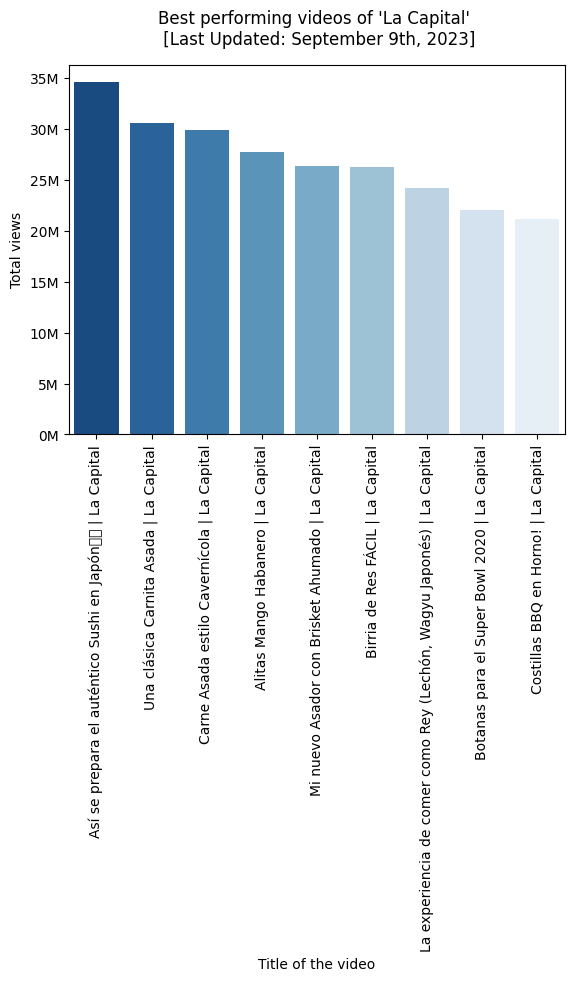

In [46]:
ax = sns.barplot(x = 'title', y = 'view_count', data = video_df.sort_values('view_count', ascending=False)[0:9], palette= 'Blues_r')

plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1_000_000) + 'M'))

ax.set_xlabel('Title of the video')
ax.set_ylabel('Total views')
plt.title("Best performing videos of 'La Capital' \n [Last Updated: September 9th, 2023]", pad= 15);

### Worst performing videos

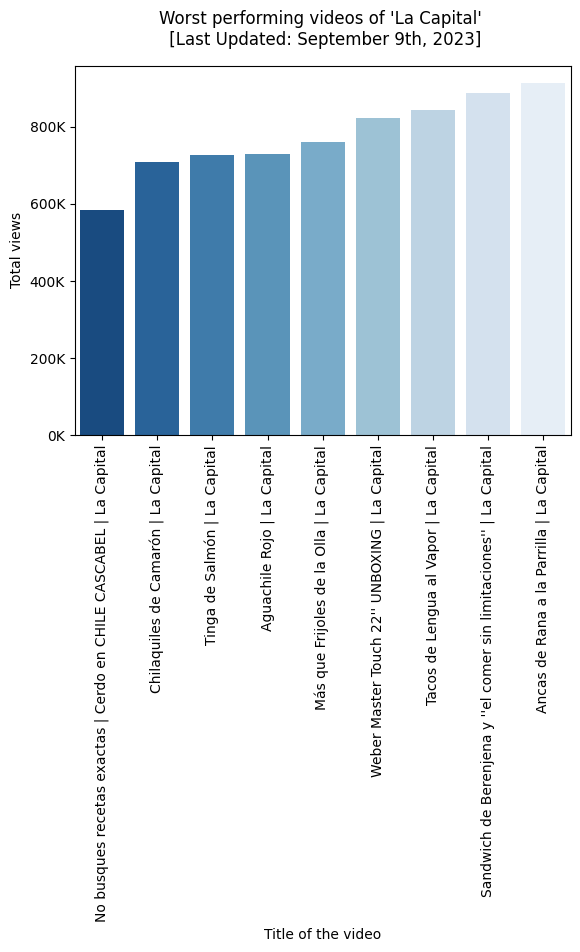

In [54]:
ax = sns.barplot(x = 'title', y = 'view_count', data = video_df.sort_values('view_count', ascending=True)[0:9], palette= 'Blues_r')
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))

ax.set_xlabel('Title of the video')
ax.set_ylabel('Total views')
plt.title("Worst performing videos of 'La Capital' \n [Last Updated: September 9th, 2023]", pad= 15);

### View distribution (Views per each video)

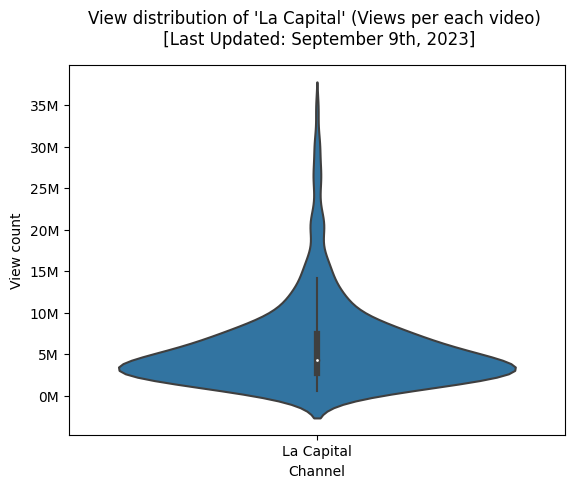

In [48]:
ax = sns.violinplot(x= video_df['channel_title'], y= video_df['view_count'])

ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1_000_000) + 'M'))

ax.set_xlabel('Channel')
ax.set_ylabel('View count')
plt.title("View distribution of 'La Capital' (Views per each video) \n [Last Updated: September 9th, 2023]", pad= 15);

### Views vs likes and comments

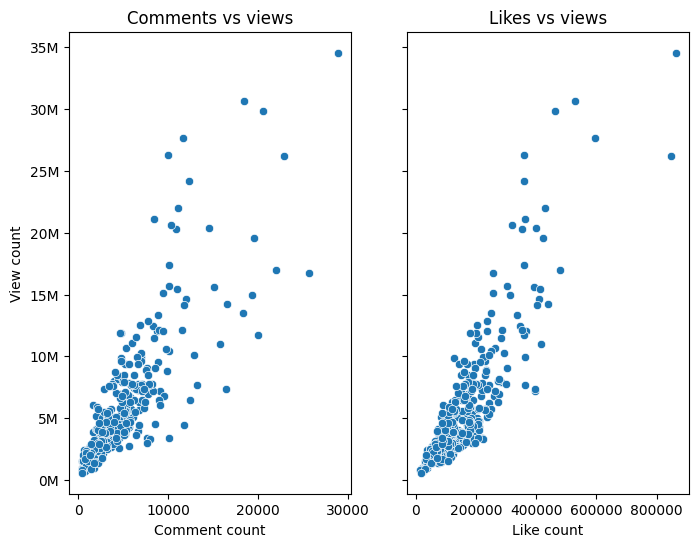

In [49]:
fig, ax = plt.subplots(1,2, figsize=(8, 6), sharey=True)

sns.scatterplot(data = video_df, x = 'comment_count', y = 'view_count', ax = ax[0])
sns.scatterplot(data = video_df, x = 'like_count', y = 'view_count', ax = ax[1])

ax[0].set(xlabel='Comment count', ylabel='View count', title='Comments vs views')
ax[1].set(xlabel='Like count', ylabel='View count', title='Likes vs views')


ax[0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1_000_000) + 'M'));

### Average video duration

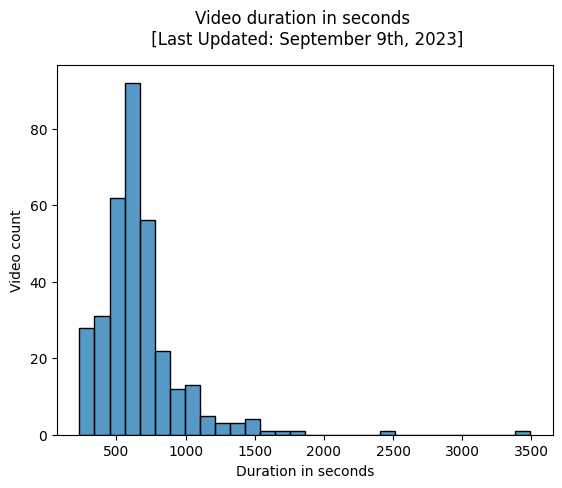

In [50]:
ax= sns.histplot(data = video_df, x = 'duration_secs', bins=30)

plt.title("Video duration in seconds \n [Last Updated: September 9th, 2023]", pad= 15)

ax.set_xlabel('Duration in seconds')
ax.set_ylabel('Video count');

### Wordcloud for video titles

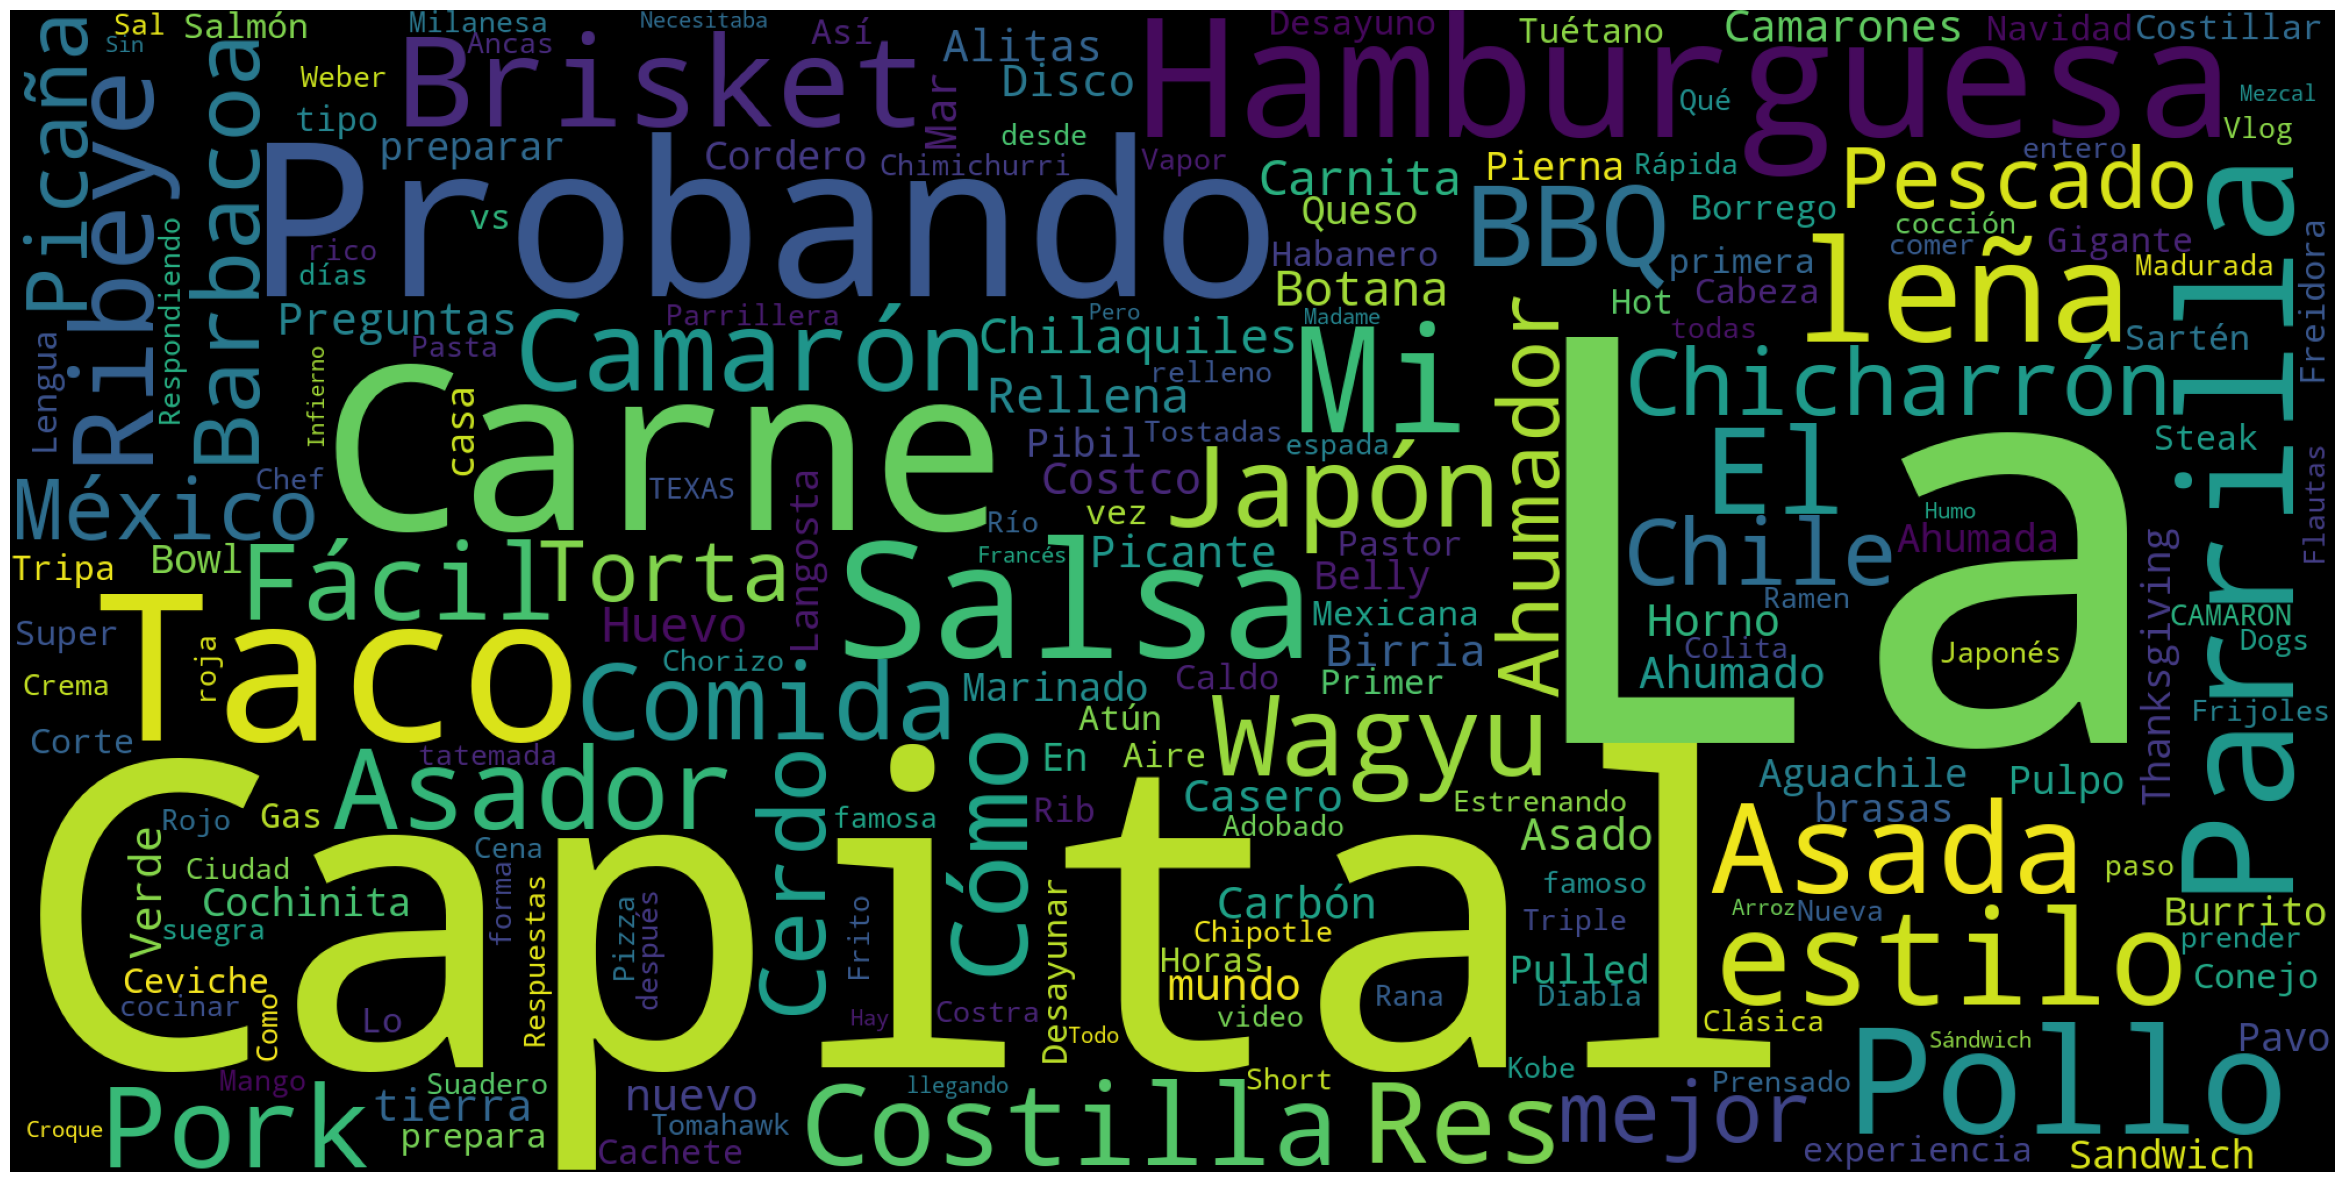

In [51]:
## Wordcloud for video titles
stop_words = set(stopwords.words('spanish'))
video_df['title_no_stopwords'] = video_df['title'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words = list([a for b in video_df['title_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words) 

def plot_cloud(wordcloud):
    plt.figure(figsize=(30, 20))
    plt.imshow(wordcloud) 
    plt.axis("off");

wordcloud = WordCloud(width = 2000, height = 1000, random_state=1, background_color='black', 
                      colormap='viridis', collocations=False).generate(all_words_str)
plot_cloud(wordcloud)

### Update schedule

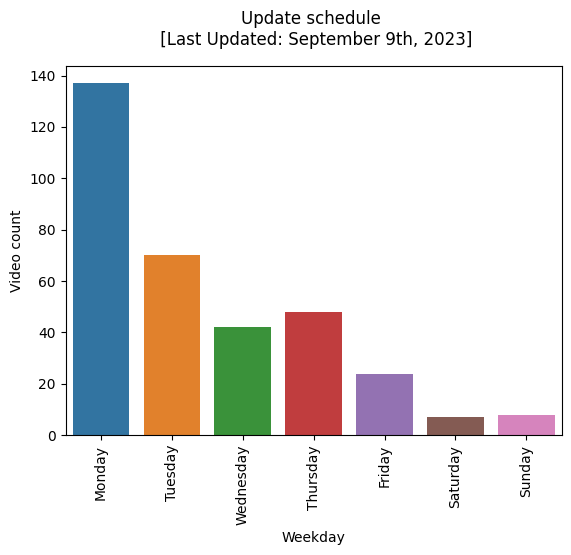

In [52]:
# Count quantity of videos and divide by weekday
day_df = pd.DataFrame(video_df['published_day_name'].value_counts())
weekdays = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_df = day_df.reindex(weekdays)

# Actual plot
ax = sns.barplot(x = 'index', y = 'published_day_name', data = day_df.reset_index())

plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

ax.set_xlabel('Weekday')
ax.set_ylabel('Video count')
plt.title('Update schedule \n [Last Updated: September 9th, 2023]', pad= 15);